In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [79]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2.5.1


device(type='cpu')

In [80]:
class setData(Dataset):
    def __init__(self, directory, transform):
        self.data = datasets.ImageFolder(root=directory, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [81]:
train_path = 'train'
val_path = 'valid'
test_path = 'test'

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_dataset = setData(train_path, transform)
test_dataset = setData(test_path, transform)

train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)


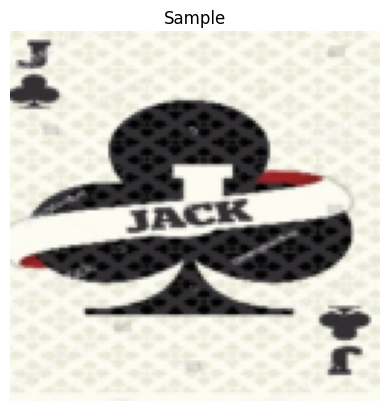

In [82]:
images, labels = next(iter(train_data))
image = np.transpose(images[1].detach(), (1,2,0))
plt.figure()
plt.title('Sample')
plt.axis('off')
plt.imshow(image)

In [83]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,
                      kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32,
                      stride=1, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        self.out = nn.Linear(5408, 53)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [96]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10
train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [97]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for X, y in tqdm(train_data, desc=f'Epoch: {epoch+1} / {epochs}'):
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = criterion(ypred, y)
        preds = torch.max(ypred, dim=1)[1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X.shape[0]
        running_acc += (y == preds).sum().item()
    acc = (running_acc / train_dataset.__len__()) * 100
    train_acc.append(acc)
    train_loss.append(running_loss)
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for X, y in tqdm(test_data, desc='Testing'):
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            preds = torch.max(ypred, dim=1)[1]
            running_acc += (y == preds).sum().item()
            loss = criterion(ypred, y)
            running_loss += loss.item() * X.shape[0]
        test_loss.append(running_loss)
        acc = (running_acc / test_dataset.__len__()) * 100
        test_acc.append(acc)


Testing: 100%|██████████| 9/9 [00:00<00:00, 23.39it/s]


[21434.134439468384, 13323.430910110474, 9779.838547706604, 6964.777285575867, 4868.089016199112, 3174.390328645706, 2417.730931162834, 1690.9367997646332, 1196.6938726305962, 1177.5134225264192]


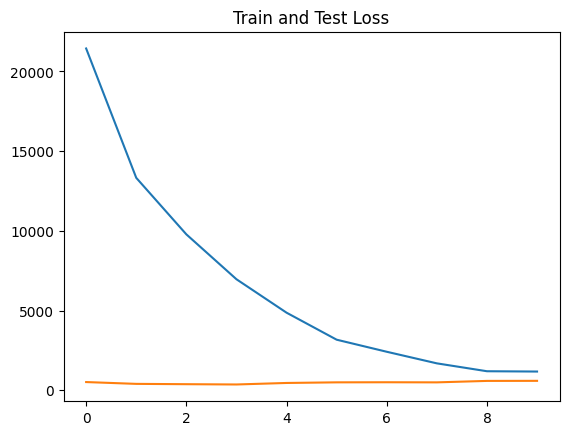

In [98]:
print(train_loss)
plt.figure()
plt.plot(range(epochs), train_loss)
plt.plot(range(epochs), test_loss)
plt.title('Train and Test Loss')
plt.show()

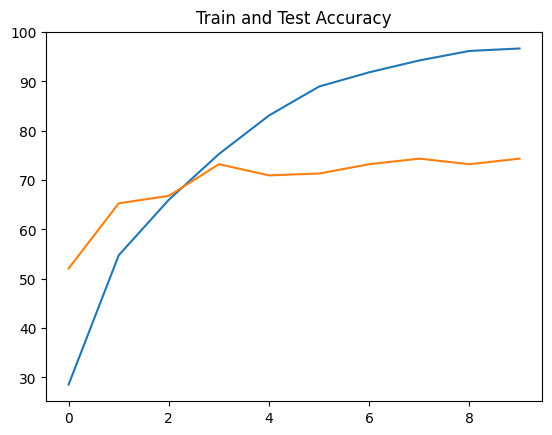

In [99]:
plt.figure()
plt.plot(range(epochs), train_acc)
plt.plot(range(epochs), test_acc)
plt.title('Train and Test Accuracy')
plt.show()